In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import shutil
import glob
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

In [2]:
xray = pd.read_csv('covid-chestxray-dataset/metadata.csv')

covid_samples = xray['finding'] == 'COVID-19'
PA_xray = xray['view'] == 'PA'

PA_covid = xray[covid_samples & PA_xray]
covid_files = [files for files in PA_covid['filename']]

In [3]:
for root, dirs, files in os.walk('covid-chestxray-dataset/images'):
    if not os.path.isdir('data/covid'):
        os.makedirs('data/covid')
    for file in files:
        if file in covid_files:
            shutil.copy(os.path.join(root, file),'data/covid')

In [4]:
filenames = glob.glob('data/covid/*')
images = [cv2.imread(img) for img in filenames]
covid = []
for img in images:
    imge = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    resized = cv2.resize(imge,(224,224), interpolation = cv2.INTER_AREA)
    #plt.imshow(resized)
    #plt.show()
    covid.append(resized)
covid = np.array(covid) / 255.0

In [5]:
filenames = glob.glob('data/no_covid/*') #from kaggle chest x ray
images = [cv2.imread(img) for img in filenames]
no_covid = []
for img in images:
    imge = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    resized = cv2.resize(imge,(224,224), interpolation = cv2.INTER_AREA)
    no_covid.append(resized)
no_covid = np.array(no_covid) / 255.0

In [6]:
print('Number of Positive COVID 19 Images: ' + str(covid.shape[0]))
print('Number of Normal Images: ' + str(no_covid.shape[0]))

covid_labels = np.ones(covid.shape[0]) 
no_covid_labels = np.zeros(no_covid.shape[0])
X = np.vstack((covid,no_covid))
y = np.hstack((covid_labels,no_covid_labels))
y = to_categorical(y)

Number of Positive COVID 19 Images: 69
Number of Normal Images: 240


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3169)

In [8]:
trainAug = ImageDataGenerator(rotation_range=15,fill_mode="nearest")

In [9]:
baseModel = VGG16(weights="imagenet", include_top = False,input_tensor=Input(shape=(224,224,3)))

W0319 16:56:06.043779 4763903424 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [11]:
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

In [12]:
opt = Adam(lr=1e-3, decay=1e-3 / 10)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [13]:
EPOCHS = 10
BS = 8
H = model.fit_generator(
	trainAug.flow(X_train, y_train, batch_size=BS),
	steps_per_epoch=len(X_train) // BS,
	validation_data=(X_test, y_test),
	validation_steps=len(X_test) // BS,
	epochs=EPOCHS)

Epoch 1/10


W0319 16:56:07.552968 4763903424 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


28/28 [==============================] - 42s 1s/step - loss: 0.5127 - acc: 0.7534 - val_loss: 0.3567 - val_acc: 0.8462
Epoch 2/10
28/28 [==============================] - 40s 1s/step - loss: 0.3866 - acc: 0.8430 - val_loss: 0.2592 - val_acc: 0.8590
Epoch 3/10
28/28 [==============================] - 38s 1s/step - loss: 0.3025 - acc: 0.9058 - val_loss: 0.2064 - val_acc: 0.9872
Epoch 4/10
28/28 [==============================] - 38s 1s/step - loss: 0.2693 - acc: 0.9148 - val_loss: 0.1517 - val_acc: 1.0000
Epoch 5/10
28/28 [==============================] - 37s 1s/step - loss: 0.1789 - acc: 0.9507 - val_loss: 0.1251 - val_acc: 1.0000
Epoch 6/10
28/28 [==============================] - 38s 1s/step - loss: 0.1513 - acc: 0.9596 - val_loss: 0.0913 - val_acc: 1.0000
Epoch 7/10
28/28 [==============================] - 36s 1s/step - loss: 0.1526 - acc: 0.9686 - val_loss: 0.0719 - val_acc: 1.0000
Epoch 8/10
28/28 [==============================] - 36s 1s/step - loss: 0.1294 - acc: 0.9598 - val_lo

In [14]:
preds = model.predict(X_test, batch_size=BS)
pred = np.argmax(preds, axis=1)

In [16]:
model.save(filepath='covid_model.h5',save_format="h5")

In [17]:
# predict on a single image 
loaded_model = tf.keras.models.load_model('covid_model.h5')
to_predict = cv2.imread('test_covid.jpeg')
imge = cv2.cvtColor(to_predict,cv2.COLOR_BGR2RGB)
resized = cv2.resize(imge,(224,224), interpolation = cv2.INTER_AREA)
pred_img = np.array(resized) / 255.0

W0319 17:02:34.314965 4763903424 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0319 17:02:34.316978 4763903424 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
pred_img = pred_img.reshape((1,224,224,3))
preds = loaded_model.predict(pred_img,batch_size=1)
pred = np.argmax(preds, axis=1)
if pred == 1:
    result = 'Positive'
else:
    result = 'Negative'

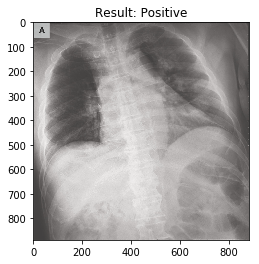

In [19]:
plt.imshow(to_predict,'gray')
plt.title('Result: '+ str(result))
plt.show()

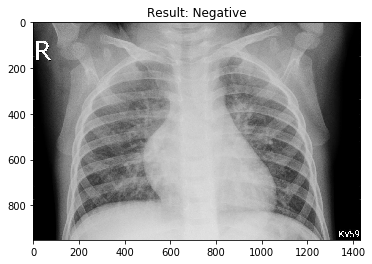

In [20]:
to_predict = cv2.imread('test_no_covid.jpeg')
imge = cv2.cvtColor(to_predict,cv2.COLOR_BGR2RGB)
resized = cv2.resize(imge,(224,224), interpolation = cv2.INTER_AREA)
pred_img = np.array(resized) / 255.0
pred_img = pred_img.reshape((1,224,224,3))
preds = loaded_model.predict(pred_img,batch_size=1)
pred = np.argmax(preds, axis=1)
if pred == 1:
    result = 'Positive'
else:
    result = 'Negative'
plt.imshow(to_predict,'gray')
plt.title('Result: '+ str(result))
plt.show()